##Water Way


In [2]:
# libs
from __future__ import division
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
from collections import defaultdict
import pandas as pd
import cv2
import os
import shapely
from shapely.geometry import MultiPolygon, Polygon

In [3]:
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands).astype(np.float32)
    for i in range(3):
        a = 0 
        b = 1 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.float32)

def CCCI_index(m, rgb):
    RE  = resize(m[5,:,:], (rgb.shape[0], rgb.shape[1])) 
    MIR = resize(m[7,:,:], (rgb.shape[0], rgb.shape[1])) 
    R = rgb[:,:,0]
    # canopy chloropyll content index
    CCCI = (MIR-RE)/(MIR+RE)*(MIR-R)/(MIR+R)
    return CCCI    

In [4]:
data = pd.read_csv('../input/train_wkt_v4.csv')
data = data[data.MultipolygonWKT != 'MULTIPOLYGON EMPTY']
grid_sizes_fname = '../input/grid_sizes.csv'
wkt_fname = '../input/train_wkt_v4.csv'
image_fname = '../input/three_band/'

## Train images ##

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


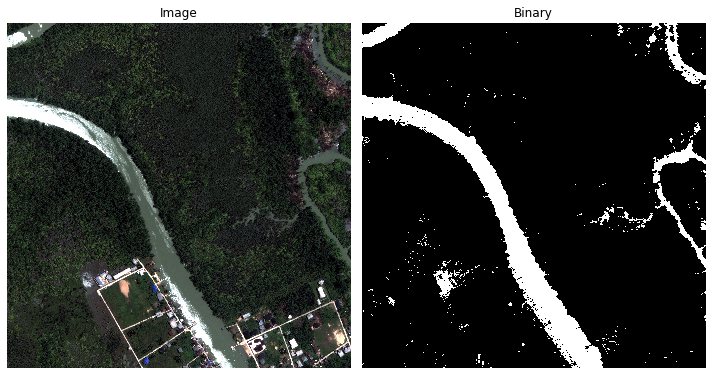

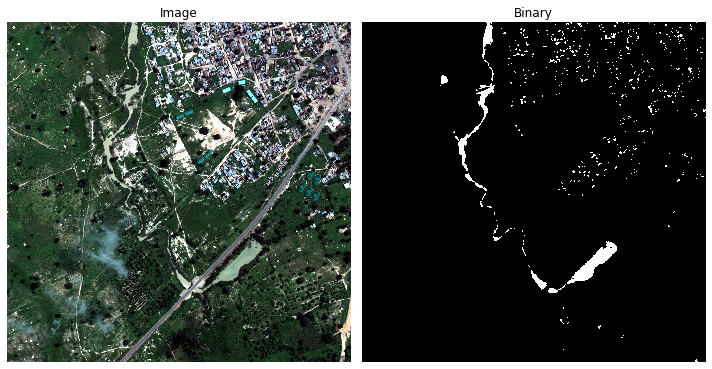

In [5]:
for IM_ID in data[data.ClassType == 7].ImageId:
    rgb = tiff.imread('../input/three_band/{}.tif'.format(IM_ID))
    rgb = np.rollaxis(rgb, 0, 3)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    
    
    
    
    CCCI = CCCI_index(m, rgb) 
    
    # you can look on histogram and pick your favorite threshold value
    binary = (CCCI > 0.11).astype(np.float32)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(stretch_8bit(rgb))
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(binary, cmap='binary_r')
    ax[1].set_title('Binary')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

## Test images ##

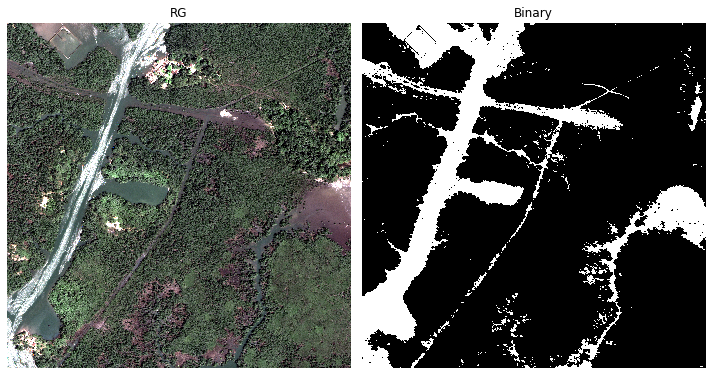

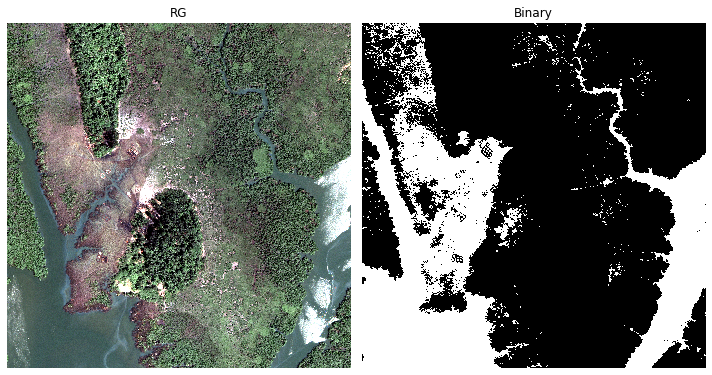

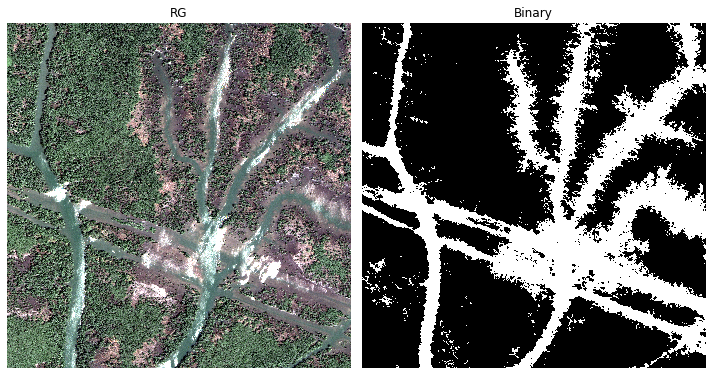

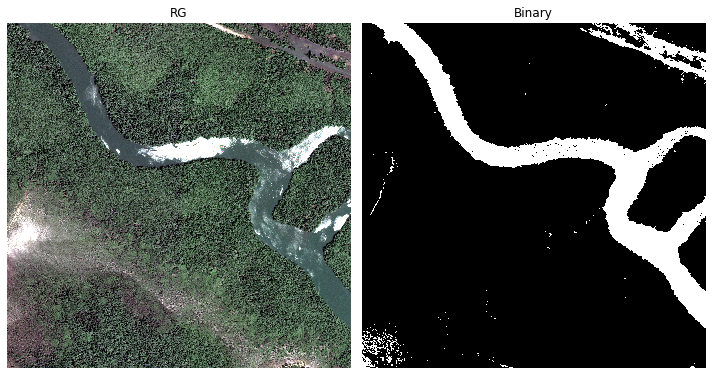

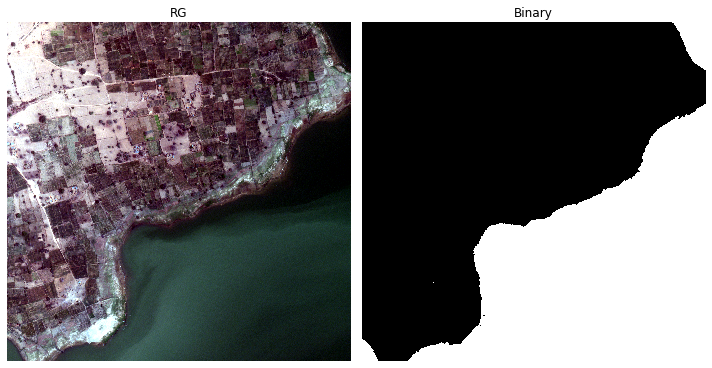

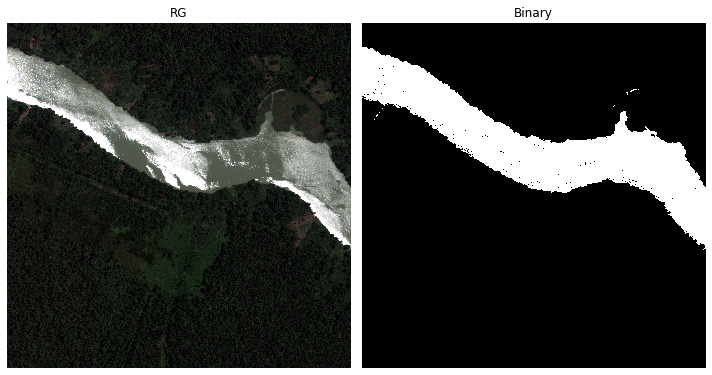

In [9]:
# take some pictures from test 
waterway_test = ['6080_4_3','6080_4_0',
                 '6080_1_3', '6080_1_1',
                 '6150_3_4', '6050_2_1']

for IM_ID in waterway_test:
    # read rgb and m bands
    rgb = tiff.imread('../input/three_band/{}.tif'.format(IM_ID))
    rgb = np.rollaxis(rgb, 0, 3)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    
    # get our index
    CCCI = CCCI_index(m, rgb) 
    
    # you can look on histogram and pick your favorite threshold value(0.11 is my best)
    binary = (CCCI > 0.11).astype(np.float32)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(stretch_8bit(rgb))
    ax[0].set_title('RG')
    ax[0].axis('off')
    ax[1].imshow(binary, cmap='binary_r')
    ax[1].set_title('Binary')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

## How to get 0.095 for WaterWay ##

- Use this idea with CCCI index
- Convert binary mask to polygons (take functions from some top kernels)
- Use threshold for number of pixels per image for filtering (> 500k pixels should work)
- Get your 0.095